<a href="https://colab.research.google.com/github/sumyu199/Project_Property/blob/main/Project_1__Property.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
from google.colab import files
import io
import numpy as np


The following data is scraped from Century 21 Global
https://www.century21global.com/

In [3]:
uploaded = files.upload()

Saving property.csv to property.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['property.csv']))


In [5]:
np.random.seed(0) 
df.head(10)

,Size(sq.ft),Size(m2),Location,Price(HKD),Price(USD),HKD/sq.ft
0,5868.0,545.15,"Kowloon Tong, Hong Kong",178000000.0,22830813.0,30334.01
1,2720.0,252.69,"Sha Tin, Hong Kong",85000000.0,10902355.0,31250.00
2,2182.0,202.71,"Sha Tin, Hong Kong",69500000.0,8914278.0,31851.51
3,1764.0,163.88,"Kowloon Tong, Hong Kong",57000000.0,7310991.0,32312.93
4,1837.0,170.66,"Sai Kung, Hong Kong",51800000.0,6644023.0,28198.15
5,1290.0,119.84,"Mid-Levels, Hong Kong",41000000.0,5258783.0,31782.95
6,1482.0,137.68,"Shek Kip Mei, Hong Kong",38000000.0,4873994.0,25641.03
7,1104.0,102.56,"Ho Man Tin, Hong Kong",36500000.0,4681599.0,33061.59
8,1208.0,112.23,"Mid-levels West, Hong Kong",34000000.0,4360942.0,28145.70
9,1624.0,150.87,"Kowloon City, Hong Kong",33800000.0,4335289.0,20812.81


**Data Cleaning**

Let see is there any missing value 

In [6]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count

Size(sq.ft)    0
Size(m2)       0
Location       0
Price(HKD)     0
Price(USD)     0
HKD/sq.ft      0
dtype: int64

Great we dont have any missing data which missing we did a good job in the data scraping 😊

**Inconsistent Data Entry**
At this point, we can see that there are Mid-levels west and Mid-levels in the Location Column so I would like to clean this column to improve the consistency of this column.

In [7]:
pip install fuzzywuzzy

In [8]:
import fuzzywuzzy
from fuzzywuzzy import process
import chardet



/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [9]:
# get all the unique values in the 'Location' column
location = df['Location'].unique()
# Sort the location alphabetically and then take a closer look
location.sort()
location

array(['Aberdeen, Hong Kong', 'Causeway Bay, Hong Kong',
       'Central, Hong Kong', 'Ho Man Tin, Hong Kong', 'Hong Kong',
       'Hung Hom, Hong Kong', 'Kennedy Town, Hong Kong',
       'Kowloon City, Hong Kong', 'Kowloon Tong, Hong Kong',
       'Kwai Chung, Hong Kong', 'Kwun Tong, Hong Kong',
       'Lam Tin, Hong Kong', 'Mid-Levels, Hong Kong',
       'Mid-levels West, Hong Kong', 'Sai Kung, Hong Kong',
       'Sha Tin, Hong Kong', 'Shek Kip Mei, Hong Kong',
       'Sheung Wan, Hong Kong', 'Stanley, Hong Kong', 'Tai Po, Hong Kong',
       'Tseung Kwan O, Hong Kong', 'Tuen Mun, Hong Kong',
       'Wan Chai, Hong Kong', 'Wong Chuk Hang, Hong Kong',
       'Yau Ma Tei, Hong Kong', 'Yau Tong, Hong Kong',
       'Yuen Long, Hong Kong'], dtype=object)

I can see some problem due to inconsistent data entry - 'Mid-Levels' and 'Mid-Levels West'
As Mid-Levels West is part of Mid-Levels west so it will affect our further analysis when we are dividing the data into segements based on loaction.
Because of this, 'Hong Kong' is not a suitable location entry as well so I will treat this as an missing value.

In [10]:
# convert to lower case
df['Location'] = df['Location'].str.lower()
# remove trailing white spaces
df['Location'] = df['Location'].str.strip()

In [11]:
# get all the unique values in the 'Location' column
Locations = df['Location'].unique()

# sort them alphabetically and then take a closer look
Locations.sort()
Locations


array(['aberdeen, hong kong', 'causeway bay, hong kong',
       'central, hong kong', 'ho man tin, hong kong', 'hong kong',
       'hung hom, hong kong', 'kennedy town, hong kong',
       'kowloon city, hong kong', 'kowloon tong, hong kong',
       'kwai chung, hong kong', 'kwun tong, hong kong',
       'lam tin, hong kong', 'mid-levels west, hong kong',
       'mid-levels, hong kong', 'sai kung, hong kong',
       'sha tin, hong kong', 'shek kip mei, hong kong',
       'sheung wan, hong kong', 'stanley, hong kong', 'tai po, hong kong',
       'tseung kwan o, hong kong', 'tuen mun, hong kong',
       'wan chai, hong kong', 'wong chuk hang, hong kong',
       'yau ma tei, hong kong', 'yau tong, hong kong',
       'yuen long, hong kong'], dtype=object)

So far besides the mentioned issue, the rest of them looks alright lets start cleaning 🧠

In [12]:
# get the top 10 closest matches to "mid-levels, hong kong"
matches = fuzzywuzzy.process.extract("mid-levels, hong kong", Locations,limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('mid-levels, hong kong', 100),
 ('mid-levels west, hong kong', 89),
 ('lam tin, hong kong', 70),
 ('sha tin, hong kong', 70),
 ('tai po, hong kong', 67),
 ('stanley, hong kong', 65),
 ('sai kung, hong kong', 63),
 ('hong kong', 62),
 ('yuen long, hong kong', 62),
 ('ho man tin, hong kong', 60)]

Lets replace all the fields that with have a ratio of > 88 with "mid-levels, hong kong"

In [13]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 88):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 88
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

In [14]:
replace_matches_in_column(df=df, column='Location', string_to_match='mid-levels, hong kong')

All done!


In [15]:

test = df['Location'].unique()

test.sort()
test

array(['aberdeen, hong kong', 'causeway bay, hong kong',
       'central, hong kong', 'ho man tin, hong kong', 'hong kong',
       'hung hom, hong kong', 'kennedy town, hong kong',
       'kowloon city, hong kong', 'kowloon tong, hong kong',
       'kwai chung, hong kong', 'kwun tong, hong kong',
       'lam tin, hong kong', 'mid-levels, hong kong',
       'sai kung, hong kong', 'sha tin, hong kong',
       'shek kip mei, hong kong', 'sheung wan, hong kong',
       'stanley, hong kong', 'tai po, hong kong',
       'tseung kwan o, hong kong', 'tuen mun, hong kong',
       'wan chai, hong kong', 'wong chuk hang, hong kong',
       'yau ma tei, hong kong', 'yau tong, hong kong',
       'yuen long, hong kong'], dtype=object)

In [16]:
df

,Size(sq.ft),Size(m2),Location,Price(HKD),Price(USD),HKD/sq.ft
0,5868.0,545.15,"kowloon tong, hong kong",178000000.0,22830813.0,30334.01
1,2720.0,252.69,"sha tin, hong kong",85000000.0,10902355.0,31250.00
2,2182.0,202.71,"sha tin, hong kong",69500000.0,8914278.0,31851.51
3,1764.0,163.88,"kowloon tong, hong kong",57000000.0,7310991.0,32312.93
4,1837.0,170.66,"sai kung, hong kong",51800000.0,6644023.0,28198.15
...,...,...,...,...,...,...
995,349.0,32.42,"tai po, hong kong",2230000.0,286026.0,6389.68
996,286.0,26.57,"tai po, hong kong",2100000.0,269352.0,7342.66
997,349.0,32.42,"tai po, hong kong",2000000.0,256526.0,5730.66
998,355.0,32.98,"tai po, hong kong",1750000.0,224460.0,4929.58


Next Lets ammend the fields with 'Hong Kong'

In [17]:
missing_location = df.loc[df['Location'] == 'hong kong'].count()
total_location = df['Location'].count()
missing_location_precent = (missing_location/total_location) * 100
missing_location_precent

Size(sq.ft)    3.1
Size(m2)       3.1
Location       3.1
Price(HKD)     3.1
Price(USD)     3.1
HKD/sq.ft      3.1
dtype: float64

Seems like there is 3.1%  of the locations not recorded 
As 3.1% wont affect our analysis much so Ive decided to save these rows in different dataframe 

In [18]:
cleaned_df = df.loc[df['Location'] != 'hong kong']
cleaned_df.reset_index()

,index,Size(sq.ft),Size(m2),Location,Price(HKD),Price(USD),HKD/sq.ft
0,0,5868.0,545.15,"kowloon tong, hong kong",178000000.0,22830813.0,30334.01
1,1,2720.0,252.69,"sha tin, hong kong",85000000.0,10902355.0,31250.00
2,2,2182.0,202.71,"sha tin, hong kong",69500000.0,8914278.0,31851.51
3,3,1764.0,163.88,"kowloon tong, hong kong",57000000.0,7310991.0,32312.93
4,4,1837.0,170.66,"sai kung, hong kong",51800000.0,6644023.0,28198.15
...,...,...,...,...,...,...,...
964,995,349.0,32.42,"tai po, hong kong",2230000.0,286026.0,6389.68
965,996,286.0,26.57,"tai po, hong kong",2100000.0,269352.0,7342.66
966,997,349.0,32.42,"tai po, hong kong",2000000.0,256526.0,5730.66
967,998,355.0,32.98,"tai po, hong kong",1750000.0,224460.0,4929.58


In [19]:
cleaned_df['Location'] = cleaned_df['Location'].str.upper()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
removed_df = df.loc[df['Location'] == 'hong kong']
removed_df.reset_index()

,index,Size(sq.ft),Size(m2),Location,Price(HKD),Price(USD),HKD/sq.ft
0,12,1659.0,154.12,hong kong,33000000.0,4232679.0,19891.50
1,46,860.0,79.90,hong kong,23000000.0,2950049.0,26744.19
2,47,842.0,78.22,hong kong,22700000.0,2911570.0,26959.62
3,50,1239.0,115.11,hong kong,21880000.0,2806394.0,17659.40
4,62,870.0,80.82,hong kong,20800000.0,2667870.0,23908.05
5,63,1199.0,111.39,hong kong,20000000.0,2565260.0,16680.57
6,124,1259.0,116.96,hong kong,16000000.0,2052208.0,12708.50
7,143,954.0,88.63,hong kong,15500000.0,1988076.0,16247.38
8,158,955.0,88.72,hong kong,14800000.0,1898292.0,15497.38
9,162,712.0,66.15,hong kong,14600000.0,1872640.0,20505.62


Data Exploration
First of All, I would like to see which location have the most properties for sale 

In [21]:
from matplotlib import pyplot as plt


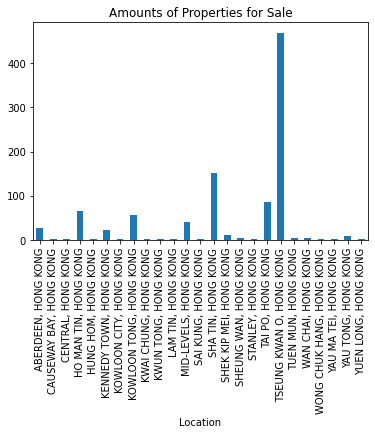

In [22]:
cleaned_df.groupby('Location')['Location'].count().plot(kind = 'bar',title = 'Amounts of Properties for Sale')


From the above chart we can see that Tsuen Kwan O is having the most amount of properties for sale 

Then I want to know the average HKD/sq. ft. of each locations




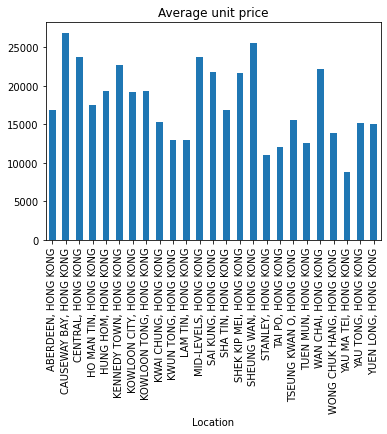

In [23]:
cleaned_df.groupby('Location')['HKD/sq.ft'].mean().plot(kind = 'bar',title = 'Average unit price')

In [24]:
grouped = cleaned_df.groupby('Location')['HKD/sq.ft'].mean().reset_index()
grouped.sort_values('HKD/sq.ft', ascending=False).reset_index()
#Rank the location those with higher unit price will have a biggest rank - might be used in the next stage 
grouped['Rank']  = grouped['HKD/sq.ft'].rank(ascending=1)

#Join two table 
cleaned_df = cleaned_df.merge(grouped, on='Location', how='left')

In [25]:
cleaned_df

,Size(sq.ft),Size(m2),Location,Price(HKD),Price(USD),HKD/sq.ft_x,HKD/sq.ft_y,Rank
0,5868.0,545.15,"KOWLOON TONG, HONG KONG",178000000.0,22830813.0,30334.01,19312.586429,16.0
1,2720.0,252.69,"SHA TIN, HONG KONG",85000000.0,10902355.0,31250.00,16864.831921,12.0
2,2182.0,202.71,"SHA TIN, HONG KONG",69500000.0,8914278.0,31851.51,16864.831921,12.0
3,1764.0,163.88,"KOWLOON TONG, HONG KONG",57000000.0,7310991.0,32312.93,19312.586429,16.0
4,1837.0,170.66,"SAI KUNG, HONG KONG",51800000.0,6644023.0,28198.15,21764.170000,19.0
...,...,...,...,...,...,...,...,...
964,349.0,32.42,"TAI PO, HONG KONG",2230000.0,286026.0,6389.68,12065.333678,3.0
965,286.0,26.57,"TAI PO, HONG KONG",2100000.0,269352.0,7342.66,12065.333678,3.0
966,349.0,32.42,"TAI PO, HONG KONG",2000000.0,256526.0,5730.66,12065.333678,3.0
967,355.0,32.98,"TAI PO, HONG KONG",1750000.0,224460.0,4929.58,12065.333678,3.0


We can see that Causeway Bay has the highest average unit price

Text(0, 0.5, 'Price(HKD)')

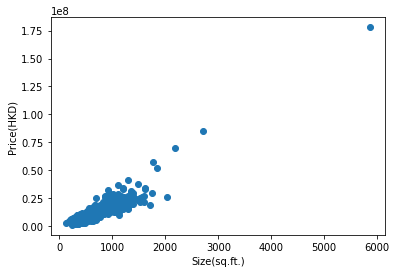

In [26]:
plt.scatter(cleaned_df['Size(sq.ft)'],cleaned_df['Price(HKD)'])
plt.xlabel('Size(sq.ft.)')
plt.ylabel('Price(HKD)')


From the above, we can tell that size and price are having postive linear relationship

**Data Analysis**
In the Final Stage, I will use Linear regression to exam whether the size and location(rank) affect the price or not 

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [28]:
x = cleaned_df['Rank']
y = cleaned_df['HKD/sq.ft_x']

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)
x_train= x_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [30]:
lm = LinearRegression()

model = lm.fit(x_train, y_train)

y_predict = lm.predict(x_test)

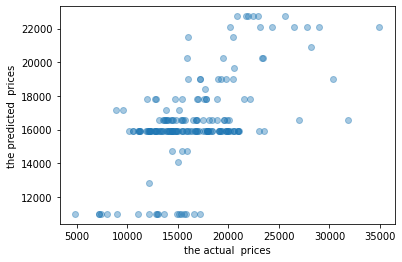

In [31]:
plt.scatter(y_test,y_predict,alpha = 0.4)
plt.xlabel("the actual  prices")
plt.ylabel("the predicted  prices")
plt.show()

In [32]:
print("Train score:")
print(lm.score(x_train, y_train))

print('Test score:')
print(lm.score(x_test,y_test))


Train score:
0.3798839378338096
Test score:
0.35259659844465585


We can tell that the location provided can not estimate the unit price of properties of different areas.
This is because unit price is determined by other features as well like the age of property and the quality of facilities.
Therefore,properties in different courts will have big difference in unit price although they are in same area.

In conculsion, if we want to estimate the unit price of a property more accuaretly, we need to collect more features of properties.

Lets save the dataframe as xlsx file 

In [33]:
pip install xlsxwriter

     |████████████████████████████████| 149 kB 13.9 MB/s 


In [34]:
import xlsxwriter
writer_obj = pd.ExcelWriter('Property_Jupyter.xlsx',
                            engine='xlsxwriter')

cleaned_df.to_excel(writer_obj, sheet_name='Sheet')

writer_obj.save()

In [35]:
from google.colab import files

files.download('Property_Jupyter.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>